In [151]:
import bagpy
from ellipse import LsqEllipse 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy import integrate
from scipy.signal import butter, filtfilt,detrend
import seaborn
seaborn.set(rc={"figure.dpi":100, 'savefig.dpi':300})
seaborn.set_context('notebook')
seaborn.set_style("ticks")


In [152]:
bag = bagpy.bagreader("E:\\NEU MAIN\\RSN\\LAB4\\Analysis\\magnetometer_cal\\data_driving.bag")
bag_string_imu = bag.message_by_topic('/imu')
bag_string_gps=bag.message_by_topic('/gps')
data_gps=pd.read_csv(bag_string_gps)
data_imu = pd.read_csv(bag_string_imu)


[INFO]  Data folder E:\NEU MAIN\RSN\LAB4\Analysis\magnetometer_cal\data_driving already exists. Not creating.


In [153]:
mag_x=data_imu["mag_field.x"][5000:].to_numpy()
mag_y=data_imu["mag_field.y"][5000:].to_numpy()

mag_x_circle = data_imu["mag_field.x"][2900:4500].to_numpy()
mag_y_circle = data_imu["mag_field.y"][2900:4500].to_numpy()

In [154]:
time_driving=data_imu['header.stamp.secs'][5000:].to_numpy()
time_driving=time_driving-time_driving[0]

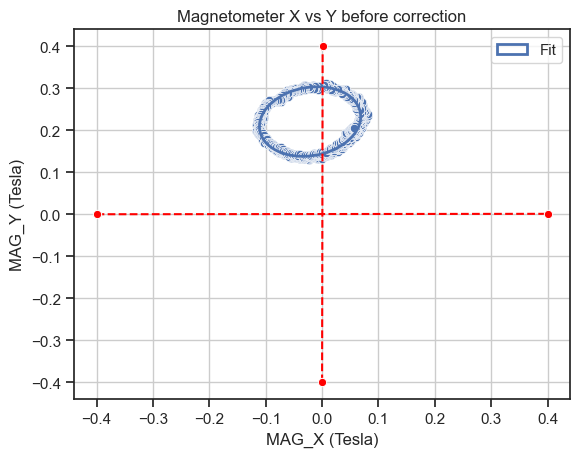

In [155]:
X=np.array(list(zip(mag_x_circle,mag_y_circle)))
reg=LsqEllipse().fit(X)
center, width, height, phi = reg.as_parameters()
fig=plt.figure()
ax=plt.subplot()
ellipse=Ellipse(xy=center,width=2*width,height=2*height,angle=np.rad2deg(phi),
edgecolor='b',fc='None',lw=2,label='Fit',zorder=2)
ax.add_patch(ellipse)
x = np.array([-0.4, 0.4])
y = np.array([0, 0.001])

seaborn.lineplot(x=x, y=y, color='red', linestyle='--', marker='o',errorbar=None)
seaborn.lineplot(x=y, y=x, color='red', linestyle='--', marker='o',errorbar=None)

seaborn.scatterplot(x=mag_x_circle,y=mag_y_circle)
plt.xlabel('MAG_X (Tesla)')
plt.grid()
plt.ylabel('MAG_Y (Tesla)')
plt.title("Magnetometer X vs Y before correction")
plt.show()


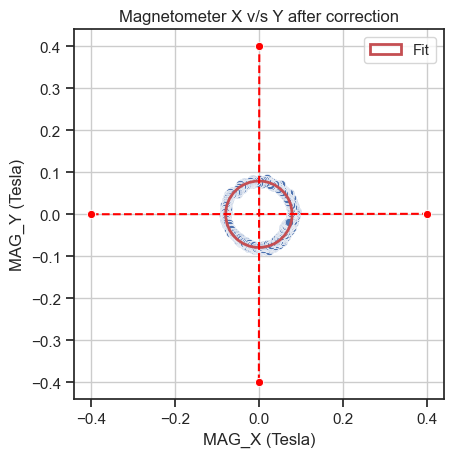

In [156]:
########## calibrate the magneto##########
R=np.array([[np.cos(phi),np.sin(phi)],
            [-np.sin(phi),np.cos(phi)]])
R_x=[]
R_y=[]
R_prime=R.T
scale_factor=width/height
for i in range(len(mag_x_circle)):
    point=np.dot(R,[mag_x_circle[i]-center[0],mag_y_circle[i]-center[1]])
    R_mag_x,R_mag_y=point
    scaled_x=R_mag_x/scale_factor
    point=np.dot(R_prime,[scaled_x,R_mag_y])
    descaled_x,descaled_y=point

    R_x.append(descaled_x)
    R_y.append(descaled_y)

post_calibration = np.array(list(zip(R_x,R_y)))
reg = LsqEllipse().fit(post_calibration)
center2, width2, height2, phi2 = reg.as_parameters()
ax = plt.subplot()

ellipse = Ellipse(
    xy=center2, width=2*width2, height=2*height2, angle=np.rad2deg(phi2),
    edgecolor='r', fc='None', lw=2, label='Fit', zorder=2
)
ax.add_patch(ellipse)

seaborn.scatterplot(x=R_x,y=R_y)

x = np.array([-0.4, 0.4])
y = np.array([0, 0.001])

seaborn.lineplot(x=x, y=y, color='red', linestyle='--', marker='o',errorbar=None)
seaborn.lineplot(x=y, y=x, color='red', linestyle='--', marker='o',errorbar=None)

plt.xlabel('MAG_X (Tesla)')
plt.grid()
plt.ylabel('MAG_Y (Tesla)')
plt.title("Magnetometer X v/s Y after correction")
plt.axis('scaled')
plt.show()
# cal_yaw=(np.arctan2(R_y,R_x))
# plt.plot(time_driving,cal_yaw,label="calibrate yaw")
# plt.legend()

Text(0.5, 1.0, 'Yaw before & after')

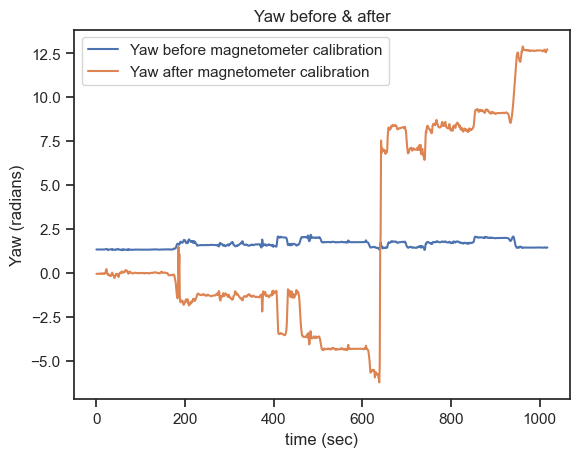

In [157]:
R=np.array([[np.cos(phi),np.sin(phi)],
            [-np.sin(phi),np.cos(phi)]])
R_x_driving=[]
R_y_driving=[]
R_prime=R.T
scale_factor=width/height
for i in range(len(mag_x)):
    point=np.dot(R,[mag_x[i]-center[0],mag_y[i]-center[1]])
    R_mag_x_cal,R_mag_y_cal=point
    scaled_x=R_mag_x_cal/scale_factor
    point=np.dot(R_prime,[scaled_x,R_mag_y_cal])
    descaled_x_cal,descaled_y_cal=point

    R_x_driving.append(descaled_x_cal)
    R_y_driving.append(descaled_y_cal)
calibrated_yaw=(np.arctan2(R_y_driving,R_x_driving))
calibrated_yaw=np.unwrap(calibrated_yaw)
yaw_before_calibration=(np.arctan2(mag_y,mag_x))
yaw_before_calibration=np.unwrap(yaw_before_calibration)
seaborn.lineplot(x=time_driving,y=yaw_before_calibration,label="Yaw before magnetometer calibration",errorbar=None)

seaborn.lineplot(x=time_driving,y=calibrated_yaw,label="Yaw after magnetometer calibration",errorbar=None)
plt.xlabel('time (sec)')
plt.ylabel('Yaw (radians)')
plt.title("Yaw before & after")

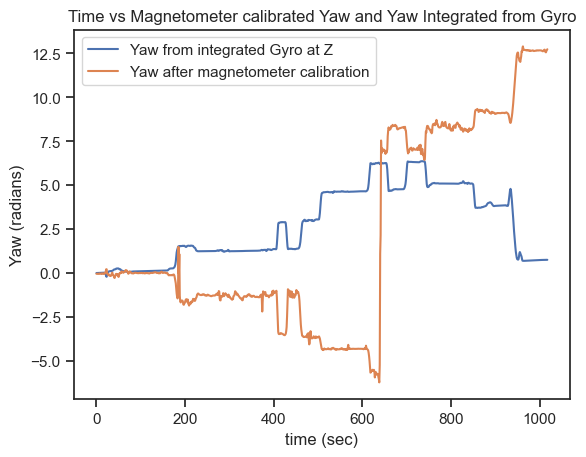

In [158]:
##### getting yaw from gyro velocity################
gyro_yaw=data_imu["angular_velocity.z"].to_numpy()
gyro_yaw=gyro_yaw[5000:]
# calibrated_yaw=np.unwrap(calibrated_yaw*-1)
yaw_from_gyro=integrate.cumtrapz(gyro_yaw,time_driving,initial=gyro_yaw[0])
seaborn.lineplot(x=time_driving,y=yaw_from_gyro,label="Yaw from integrated Gyro at Z",errorbar=None)
seaborn.lineplot(x=time_driving,y=calibrated_yaw,label="Yaw after magnetometer calibration",errorbar=None)
plt.xlabel('time (sec)')
plt.ylabel('Yaw (radians)')
plt.title("Time vs Magnetometer calibrated Yaw and Yaw Integrated from Gyro")
plt.legend()

<AxesSubplot: >

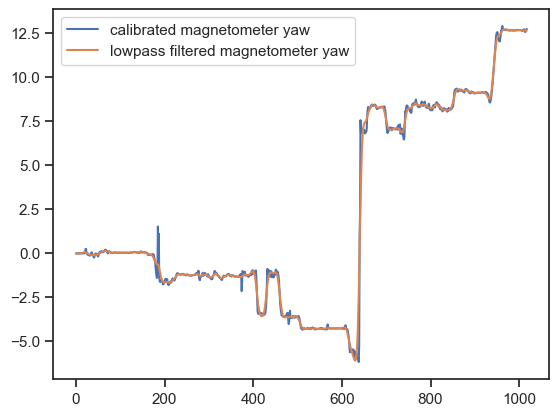

In [159]:
######### low pass filter for magnotometer yaw###########
T=len(time_driving)
fs=20
low_cutoff=0.05
nyq = 0.5 * fs
order=2
low_normal_cutoff=low_cutoff/nyq
b, a = butter(order,low_normal_cutoff, btype='low')
lowpass_yaw_mag=filtfilt(b,a,calibrated_yaw)
seaborn.lineplot(x=time_driving,y=calibrated_yaw,label="calibrated magnetometer yaw",errorbar=None)
seaborn.lineplot(x=time_driving,y=lowpass_yaw_mag,label="lowpass filtered magnetometer yaw",errorbar=None)

<AxesSubplot: >

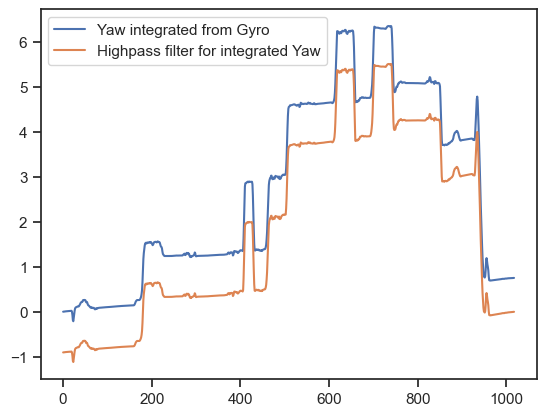

In [160]:
##########high_pass ##########
high_cutoff=0.0001
high_normal_cutoff=high_cutoff/nyq
c,d=butter(order,high_normal_cutoff, btype='high')
highpass_yaw_integrated=filtfilt(c,d,yaw_from_gyro)
seaborn.lineplot(x=time_driving,y=yaw_from_gyro,label="Yaw integrated from Gyro",errorbar=None)
seaborn.lineplot(x=time_driving,y=highpass_yaw_integrated,label="Highpass filter for integrated Yaw",errorbar=None)

Text(0, 0.5, 'Yaw (radians)')

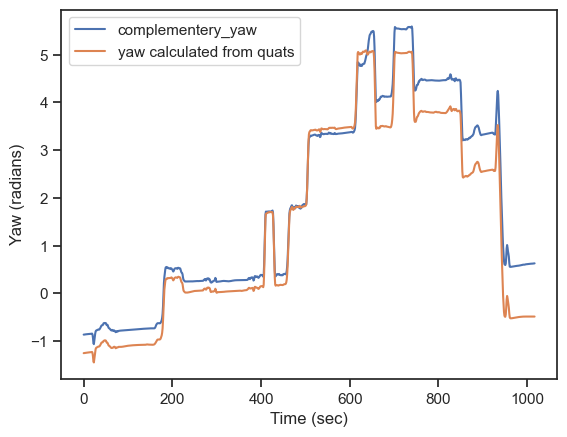

In [161]:
alpha=0.05
complementary_yaw = alpha * lowpass_yaw_mag + (1 - alpha) * (highpass_yaw_integrated)
seaborn.lineplot(x=time_driving,y=complementary_yaw,label="complementery_yaw",errorbar=None)
# #########IMU yaw###################
x=data_imu["imu.x"][5000:].to_numpy()
y=data_imu["imu.y"][5000:].to_numpy()
z=data_imu["imu.z"][5000:].to_numpy()
w=data_imu["imu.w"][5000:].to_numpy()
yaw_quat = np.arctan2(2*(x*y + z*w), 1-2*(y**2 + z**2))
yaw_quat=np.unwrap(yaw_quat)
seaborn.lineplot(x=time_driving,y=yaw_quat,label="yaw calculated from quats",errorbar=None)
plt.xlabel('Time (sec)')
plt.ylabel('Yaw (radians)')

Text(0.5, 1.0, 'Yaw vs Time for all filters and Original Yaw')

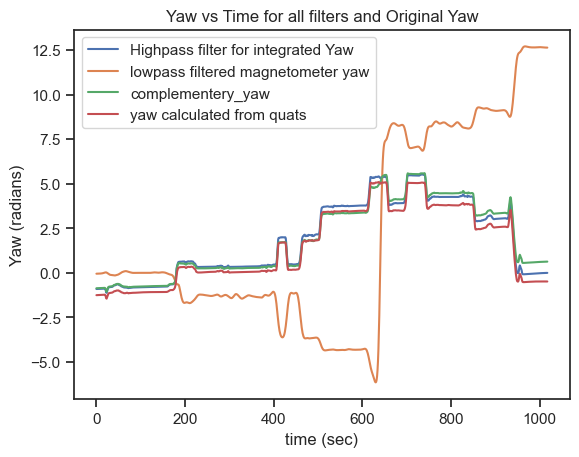

In [162]:
seaborn.lineplot(x=time_driving,y=highpass_yaw_integrated,label="Highpass filter for integrated Yaw",errorbar=None)
seaborn.lineplot(x=time_driving,y=lowpass_yaw_mag,label="lowpass filtered magnetometer yaw",errorbar=None)
seaborn.lineplot(x=time_driving,y=complementary_yaw,label="complementery_yaw",errorbar=None)
seaborn.lineplot(x=time_driving,y=yaw_quat,label="yaw calculated from quats",errorbar=None)
plt.xlabel('time (sec)')
plt.ylabel('Yaw (radians)')
plt.title("Yaw vs Time for all filters and Original Yaw")


<AxesSubplot: >

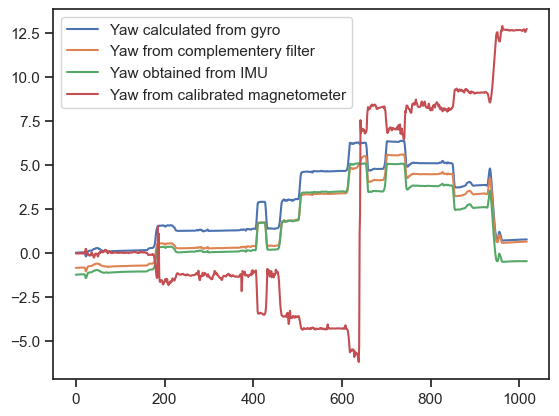

In [163]:
seaborn.lineplot(x=time_driving,y=yaw_from_gyro,label='Yaw calculated from gyro',errorbar=None)
seaborn.lineplot(x=time_driving,y=complementary_yaw,label='Yaw from complementery filter',errorbar=None)
seaborn.lineplot(x=time_driving,y=yaw_quat,label='Yaw obtained from IMU',errorbar=None)
seaborn.lineplot(x=time_driving,y=calibrated_yaw,label='Yaw from calibrated magnetometer',errorbar=None)

Text(0, 0.5, 'Acceleration (m/s**2)')

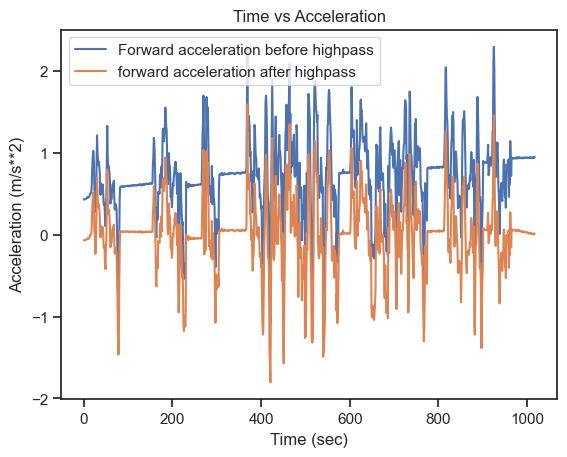

In [164]:
forward_accel=data_imu["linear_acceleration.x"][5000:].to_numpy()
seaborn.lineplot(x=time_driving,y=forward_accel,label='Forward acceleration before highpass',errorbar=None)
low_cutoff_new=0.002
order=3
fs=20
nyq=0.5*fs
normal_low_new=low_cutoff_new/nyq
b,a=butter(order,normal_low_new,btype='high')
forward_accel_highpass=filtfilt(b,a,forward_accel)
seaborn.lineplot(x=time_driving,y=forward_accel_highpass,label="forward acceleration after highpass",errorbar=None)
plt.title('Time vs Acceleration')
plt.xlabel("Time (sec)")
plt.ylabel("Acceleration (m/s**2)")

Text(0, 0.5, 'Acceleration (m/s**2)')

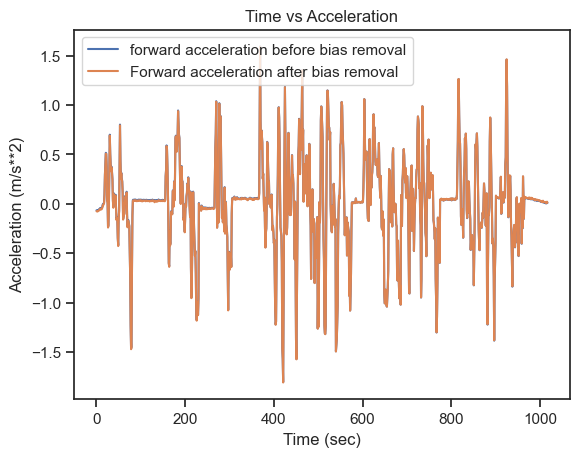

In [165]:
# #######Forward accel to estimate forward vel#########
seaborn.lineplot(x=time_driving,y=forward_accel_highpass,label="forward acceleration before bias removal",errorbar=None)
detrend_accel=detrend(forward_accel_highpass)
seaborn.lineplot(x=time_driving,y=detrend_accel,label="Forward acceleration after bias removal",errorbar=None)
plt.title('Time vs Acceleration')
plt.xlabel("Time (sec)")
plt.ylabel("Acceleration (m/s**2)")

Text(0, 0.5, 'Velocity m/s')

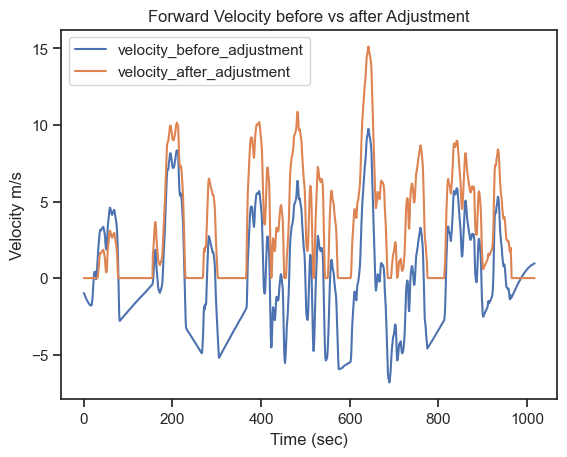

In [166]:
detrend_accel=detrend_accel-detrend_accel[0]
dt=0.05
forward_accel_no=forward_accel-forward_accel[0]
calculate_vel_imu_adjust=integrate.cumtrapz(detrend_accel,dx=dt,initial=detrend_accel[0])
calculate_vel_imu_before=integrate.cumtrapz(forward_accel_no,dx=dt,initial=forward_accel_no[0])
detrend_velo_after=detrend(calculate_vel_imu_adjust)
seaborn.lineplot(x=time_driving,y=detrend_velo_after,label='velocity_before_adjustment',errorbar=None)
scale=np.ones_like(detrend_velo_after)
difference_vel=np.diff(detrend_velo_after)
slope=0.01
shape=500
window=[]
for i in range(len(detrend_velo_after)-shape):
    win_diff=difference_vel[i:i+shape]
    if np.all(np.abs(win_diff)<slope):
        window.append((i,i+shape))
for win in window:
    scale[win[0]:win[1]]=0
start=0
end=0
for i in range(len(scale)):
    if(scale[i]==1):
        end=i
    else:
        if end>start:
            min=np.min(detrend_velo_after[start:end])
            detrend_velo_after[start-1:end]=detrend_velo_after[start-1:end]-min
            start=i
detrend_velo_after=detrend_velo_after-1.5
detrend_velo_after[scale==0]=0
detrend_velo_after[detrend_velo_after<0]=0
seaborn.lineplot(x=time_driving,y=detrend_velo_after,label='velocity_after_adjustment',errorbar=None)


# seaborn.lineplot(x=time_driving,y=calculate_vel_imu_adjust,label='velocity_after_adjustment',errorbar=None)
plt.xlabel('Time (sec)')
plt.title("Forward Velocity before vs after Adjustment")
plt.ylabel("Velocity m/s")

Text(0, 0.5, 'Velocity m/s')

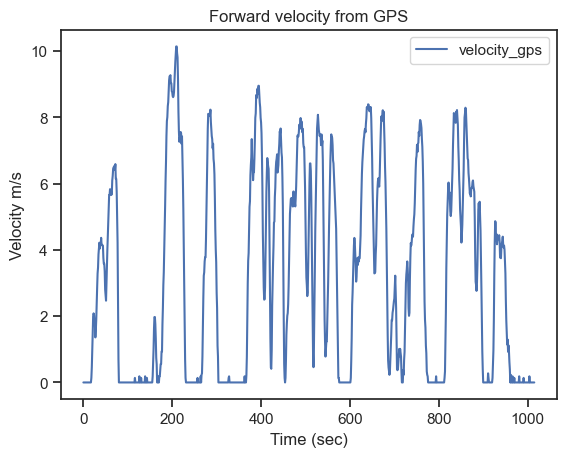

In [167]:
utm_northing=data_gps["UTM_northing"][500:].to_numpy()
utm_northing=utm_northing-utm_northing[0]
utm_easting=data_gps["UTM_easting"][500:].to_numpy()
utm_easting=utm_easting-utm_easting[0]
gps_time=data_gps["Header.stamp.secs"][500:].to_numpy()
gps_time=gps_time-gps_time[0]
velocity_gps=[]
velo_x=[]
velo_y=[]
for i in range(len(utm_northing)-2):
    velo_x.append((utm_easting[i+2]-utm_easting[i])/(gps_time[i+2]-gps_time[i]))
    velo_y.append((utm_northing[i+2]-utm_northing[i])/(gps_time[i+2]-gps_time[i]))
    magnitude=np.sqrt(velo_x[i]**2+velo_y[i]**2)
    velocity_gps.append(magnitude)
seaborn.lineplot(x=gps_time[:-2],y=velocity_gps,label='velocity_gps',errorbar=None)
plt.xlabel('Time (sec)')
plt.title("Forward velocity from GPS")
plt.ylabel("Velocity m/s")

Text(0, 0.5, 'Velocity m/s')

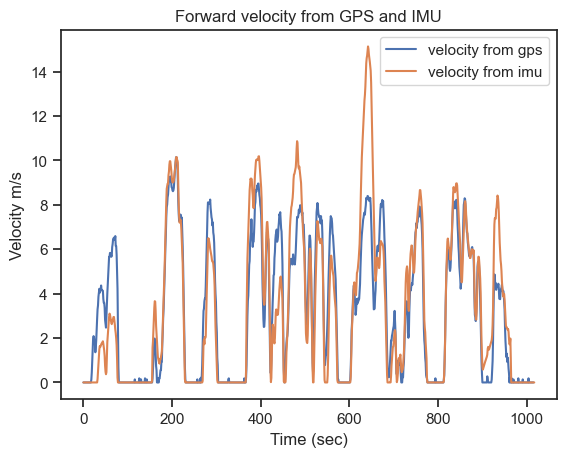

In [168]:
seaborn.lineplot(x=gps_time[:-2],y=velocity_gps,label='velocity from gps',errorbar=None)
plt.xlabel('Time (sec)')
seaborn.lineplot(x=time_driving,y=detrend_velo_after,label='velocity from imu',errorbar=None)

plt.title("Forward velocity from GPS and IMU")
plt.ylabel("Velocity m/s")

(2031,) (2033,)


Text(0, 0.5, 'Distance (meter)')

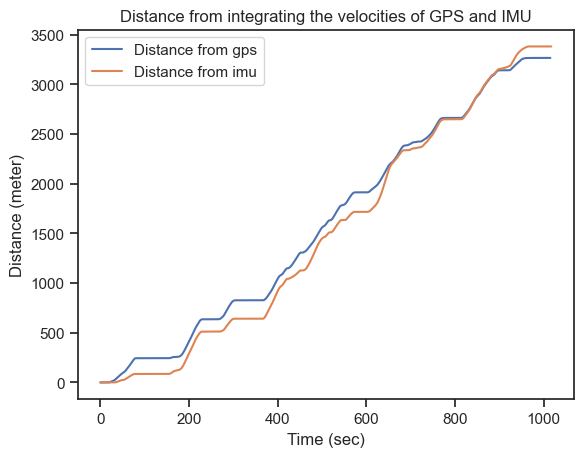

In [169]:
####### dead reckoning#######
dt=0.05
d_gps=0.5
imu_dist=integrate.cumtrapz(detrend_velo_after,dx=dt,initial=detrend_velo_after[0])
gps_dist=integrate.cumtrapz(velocity_gps,dx=d_gps,initial=velocity_gps[0])
print(gps_dist.shape,gps_time.shape)
seaborn.lineplot(x=gps_time[:-2],y=gps_dist,label='Distance from gps',errorbar=None)
seaborn.lineplot(x=time_driving,y=imu_dist,label='Distance from imu',errorbar=None)
plt.title('Distance from integrating the velocities of GPS and IMU')
plt.xlabel('Time (sec)')
plt.ylabel('Distance (meter)')

Text(0, 0.5, 'Acceleration (m/s**2)')

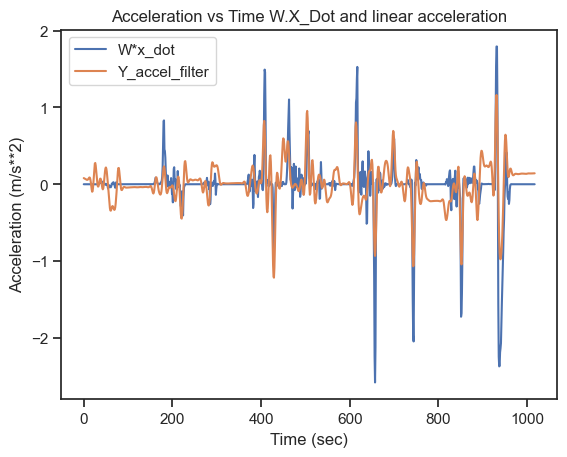

In [170]:
Y_accel=data_imu['linear_acceleration.y'][5000:]-data_imu['linear_acceleration.y'][5000]
X_velocity=detrend_velo_after
W=data_imu['angular_velocity.z'][5000:]
W_x_dot=W*X_velocity
fs=20
lp_fc=0.1
order=4
nyq=0.5*fs
normal_low_dead=lp_fc/nyq
b,a=butter(order,normal_low_dead,btype='lowpass')
Y_accel_filter=filtfilt(b,a,Y_accel)
Y_accel_filter=detrend(Y_accel_filter)
seaborn.lineplot(x=time_driving,y=W_x_dot,label='W*x_dot',errorbar=None)
seaborn.lineplot(x=time_driving,y=Y_accel_filter,label='Y_accel_filter',errorbar=None)
plt.title("Acceleration vs Time W.X_Dot and linear acceleration")
plt.xlabel('Time (sec)')
plt.ylabel("Acceleration (m/s**2)")


Text(0, 0.5, 'Northing (meter)')

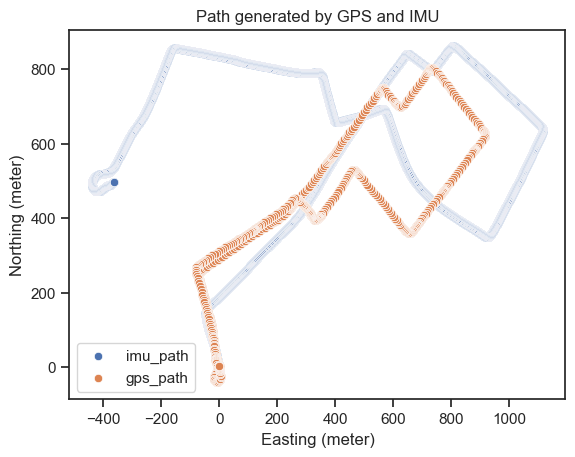

In [171]:
Velo_N=np.cos(complementary_yaw-0.4)*detrend_velo_after -np.sin(complementary_yaw-0.4)*detrend_velo_after
Velo_E=np.sin(complementary_yaw-0.4)*detrend_velo_after +np.cos(complementary_yaw-0.4)*detrend_velo_after
X_E=integrate.cumtrapz(Velo_E,dx=0.05,initial=Velo_E[0])
X_N=integrate.cumtrapz(Velo_N,dx=0.05,initial=Velo_N[0])

Easting=data_gps['UTM_easting'][500:]-data_gps['UTM_easting'][500]
Northing=data_gps['UTM_northing'][500:]-data_gps['UTM_northing'][500]
seaborn.scatterplot(x=X_E/1.2,y=X_N/1.2,label="imu_path")
seaborn.scatterplot(x=Easting,y=Northing,label="gps_path")
plt.title('Path generated by GPS and IMU')
plt.xlabel('Easting (meter)')
plt.ylabel('Northing (meter)')

In [174]:
###xc####
omega=data_imu['angular_velocity.z'][5000:]
w_dot=np.diff(omega)/0.05
xc=(Y_accel[1:]-W_x_dot[1:])/(w_dot)
print(np.median(xc))

0.6052791570133108


C:\Users\nitin\AppData\Local\Temp\ipykernel_7576\2886477381.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  xc=(Y_accel[1:]-W_x_dot[1:])/(w_dot)
